In [3]:
# read the port S11 data from folder port-impedance/resonator_port-S.csv ( f (GHz),|S[1][1]| (dB),arg(S[1][1]) (deg.)) and plot it
import numpy as np
import matplotlib.pyplot as plt
import os
import sys
import re
import csv
import argparse
import math
import cmath
from scipy import signal
from scipy.optimize import curve_fit
from scipy.signal import find_peaks
from scipy.signal import peak_widths
from scipy.signal import peak_prominences
from scipy.signal import peak_widths
from scipy.signal import savgol_filter
from scipy.signal import butter, lfilter
from scipy.signal import freqz
from scipy.signal import argrelextrema


def read_csv_file(file_name):
    with open(file_name, 'r') as csvfile:
        csvreader = csv.reader(csvfile)
        data = []
        for row in csvreader:
            data.append(row)
    return data

# ignore the first row
Scatter_data = read_csv_file('data-1Q1R/port-S.csv')[1:]


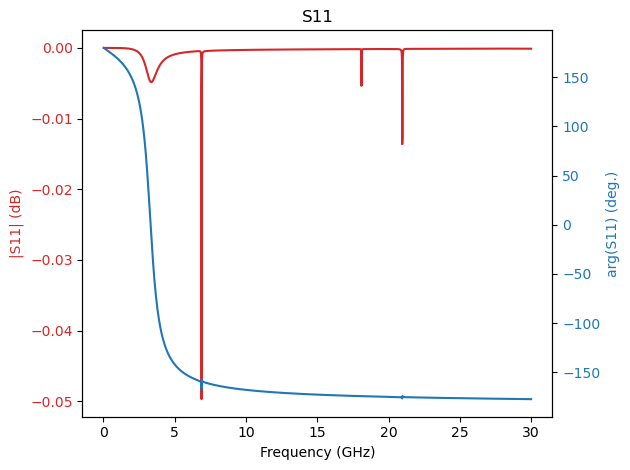

In [6]:
# plot S11 data from the csv file
f = []
S11 = []
argS11 = []
for row in Scatter_data:
    f.append(float(row[0]))
    S11.append(float(row[3]))
    argS11.append(float(row[4]))

# plot the amplitude and phase of S11 in same figure with left and right y-axis
fig, ax1 = plt.subplots()
color = 'tab:red'
ax1.set_xlabel('Frequency (GHz)')
ax1.set_ylabel('|S11| (dB)', color=color)
ax1.plot(f, S11, color=color)
ax1.tick_params(axis='y', labelcolor=color)
ax2 = ax1.twinx()
color = 'tab:blue'
ax2.set_ylabel('arg(S11) (deg.)', color=color)
ax2.plot(f, argS11, color=color)
ax2.tick_params(axis='y', labelcolor=color)
plt.title('S11')
fig.tight_layout()
plt.show()


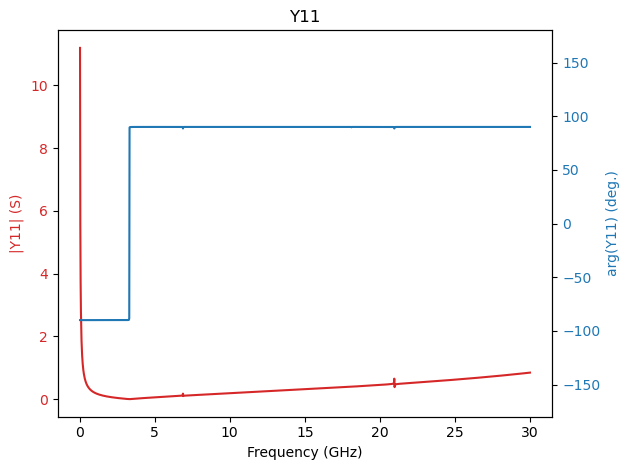

In [7]:
# transform the S11 data to Y11 data
S11 = np.array(S11)
argS11 = np.array(argS11)
S11_data = np.exp(1j*np.deg2rad(argS11))*10**(S11/20)

Z0 = 50
Z11_data = Z0*(1+S11_data)/(1-S11_data)
Y11_data = 1/Z11_data

# plot the amplitude and phase of Y11 in same figure with left and right y-axis
fig, ax1 = plt.subplots()
color = 'tab:red'
ax1.set_xlabel('Frequency (GHz)')
ax1.set_ylabel('|Y11| (S)', color=color)
ax1.plot(f, np.abs(Y11_data), color=color)
ax1.tick_params(axis='y', labelcolor=color)
ax2 = ax1.twinx()
color = 'tab:blue'
ax2.set_ylabel('arg(Y11) (deg.)', color=color)
ax2.plot(f, np.angle(Y11_data, deg=True), color=color)
ax2.tick_params(axis='y', labelcolor=color)
ax2.set_ylim(-180, 180)
plt.title('Y11')
fig.tight_layout()
plt.show()



peaks: [ 343  904 1047]
widths: (array([1.15947013, 0.8559666 , 1.9877623 ]), array([0.13748824, 0.39766071, 0.51796502]), array([ 342.34052987,  903.6440334 , 1045.5122377 ]), array([ 343.5,  904.5, 1047.5]))
prominences: [7.64473901e-02 2.54482773e-04 2.69572676e-01]


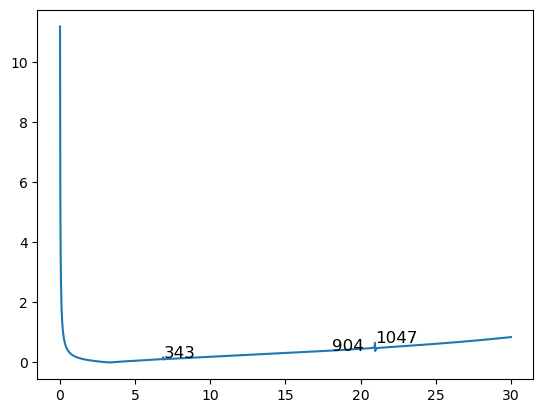

In [8]:
# find peaks in S11 data
peaks, _ = find_peaks(np.abs(Y11_data), height=-10, distance=10)
widths = peak_widths(np.abs(Y11_data), peaks, rel_height=0.5)
prominences = peak_prominences(np.abs(Y11_data), peaks)[0]
print('peaks:', peaks)
print('widths:', widths)
print('prominences:', prominences)
# plot the peaks
plt.plot(f, np.abs(Y11_data))
for i in peaks:
    plt.text(f[i], np.abs(Y11_data)[i], str(i), fontsize=12)
plt.show()


In [9]:
# solve the equivalent resonator circuit parameters at each peak
delta_f = (f[1] - f[0])*1e9
Y11imag_diff = np.diff(np.imag(Y11_data)) / delta_f

for i in peaks:
    f0 = f[i]*1e9
    Y11 = Y11_data[i]

    C_1 = 1/2 *Y11imag_diff[i+1]
    L_1 = 1 / f0**2 / C_1
    print('idx:', i)
    print('f0:', f0)
    print('C_1:', C_1)
    print('L_1:', L_1)
    print('Q:', np.abs(f0 / np.imag(Y11)))


delta_f = (f[1] - f[0])*1e9
C_0 = Y11imag_diff[1]

print('C_0:', C_0)

idx: 343
f0: 6880000000.0
C_1: 1.6358630386909788e-10
L_1: 1.2914457982375815e-10
Q: 39167700595.5581
idx: 904
f0: 18100000000.0
C_1: 2.0714265250820764e-11
L_1: 1.473578638024546e-10
Q: 45502496402.97561
idx: 1047
f0: 20960000000.0
C_1: 1.540439609810923e-09
L_1: 1.4776540420924074e-12
Q: 32120787321.198887
C_0: 9.326748871292711e-08


### Derivation of the coupling strength

In [6]:
from scipy.constants import hbar, e
Phi0 = hbar /(2*e)
h = hbar*(2*np.pi)

In [13]:
import numpy as np
C_0 = 6.45e-7/1e9/2/np.pi
C_1 = C_0 / 0.025
L_1 = 1/(2*np.pi*5.4283e9)**2 /C_1

In [14]:
C_0

1.0265493829427248e-16

In [15]:
EJ = 20e9 # GHz
C_sum = 300e-15 # 1 fF

print('C1 = {:.2f} fF | L1 = {:.2f} nH'.format(C_1/1e-15, L_1/1e-9))
print('C0 = {:.2f} fF'.format(C_0/1e-15))

C1 = 4.11 fF | L1 = 209.35 nH
C0 = 0.10 fF


In [16]:
beta = C_0 / (C_1 + C_sum)

Ec_phi = e**2 / (2*(C_sum + 1/(1/C_0 + 1/C_1))) / h
Ec_tha = e**2 / (2*(C_1 + 1/(1/C_0 + 1/C_sum))) / h
Ec_tha_phi = beta* e**2 / (2*(C_0 + 1/(1/C_1 + 1/C_sum))) / h
EL = Phi0**2 / L_1 / h

nzp_tha = 1/2 * (EL/(2*Ec_tha))**(1/4)
nzp_phi = 1/2 * (EL/(2*Ec_phi))**(1/4)

g = 8*Ec_tha_phi*nzp_phi*nzp_tha /1e6 # MHz
print('g = %.3f MHz'%g)

g = 2.665 MHz
